The following code is from
[Link](https://github.com/justinbois/rdsolver/blob/master/notebooks/asdm_example.ipynb)

> The equations are as follows

<h3><center>$\partial_t u = D_u (\partial_x^2 + \partial_y^2)u + \epsilon(v - \alpha u)$</center></h3>

<h3><center>$\partial_t v = D_v (\partial_x^2 + \partial_y^2)v -u + \mu v - v^3$</center></h3>

With parameters  :
- $D_u = 0.05, \quad D_v=0.00028$.
- $\alpha = 1.0$.
- $\epsilon = 1.0$.
- $\mu = 1.0$.

In [1]:
%config Completer.use_jedi = False
import numpy as np
import numba
import scipy.integrate
from matplotlib import pyplot as plt

import rdsolver

In [2]:
D, beta, gamma, f, f_args, homo_ss = rdsolver.models.asdm()

In [3]:
D

array([0.005, 0.2  ])

In [4]:
beta

array([0.  , 0.02])

In [5]:
gamma

array([[-0.01,  0.  ],
       [ 0.  ,  0.  ]])

In [6]:
#f()
# rho_a, rho_s, kappa_a
f_args

(0.01, 0.02, 0.25)

In [7]:
homo_ss

array([1.  , 1.25])

In [8]:
@numba.jit(nopython=True)
def f(c, t):
    u = c[0, :, :]
    v = c[1, :, :]        
    fu = np.zeros_like(u)
    fv = - v*v*v
    return np.stack((fu, fv))


In [9]:
63*63/101

39.2970297029703

In [10]:
homo_ss

array([1.  , 1.25])

In [27]:

# Set up the space and time grid
n = (64, 64)
#L = (31*31/201, 31*31/201)
#L = (1, 1)
L = (1., 1.)
t = np.linspace(0, 64, 256)


alpha = 1.0
epsilon = 10.0#6.0
mu = 1.4#1.4


D[0] = 0.05# D_u
D[1] = 0.00028# D_v

beta[0] = 0.00#  
beta[1] = 0.00#  

gamma[0,0] = -epsilon*alpha#
gamma[0,1] = epsilon#
gamma[1,0] = -1.0#
gamma[1,1] = mu#

homo_ss[0] = 0.1#1.00
homo_ss[1] = 0.1#1.00

f_args = ()


# Initial condition and solve
c0 = rdsolver.initial_condition(uniform_conc=homo_ss, n=n, L=L)

c = rdsolver.solve(c0, t, D=D, beta=beta, gamma=gamma, f=f, f_args=f_args, L=L)

# Interpolate the solution
c_interp = rdsolver.viz.interpolate_concs(c)

100%|██████████| 256/256 [00:15<00:00, 16.38it/s] 


# Original solutions

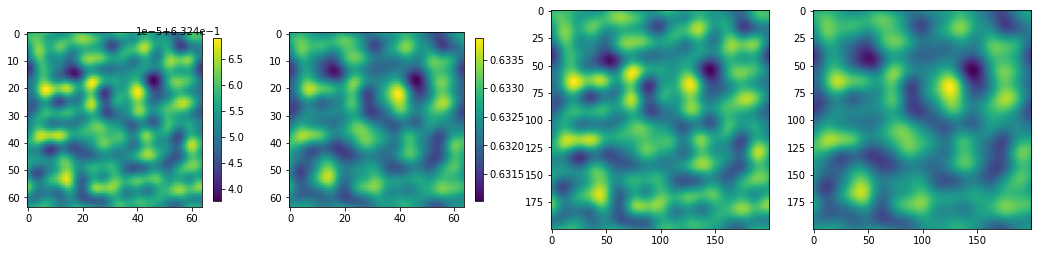

In [33]:
_ = plt.figure(figsize=(18,6))
index = -1
# Direct solution
plt.subplot(141)
plt.imshow(c[0, :, :, index])
plt.colorbar(shrink=.5)
plt.subplot(142)
plt.imshow(c[1, :, :, index])
plt.colorbar(shrink=.5)
# Interpolated solutions
plt.subplot(143)
plt.imshow(c_interp[0, :, :, index])
plt.subplot(144)
plt.imshow(c_interp[1, :, :, index])
plt.show()

In [10]:
# with open('../turing_model_2.npy', 'wb') as f:
#     np.save(f, c)
    
# with open('../turing_t_model_2.npy', 'wb') as f:
#     np.save(f, t)
   

# Estimated Solutions

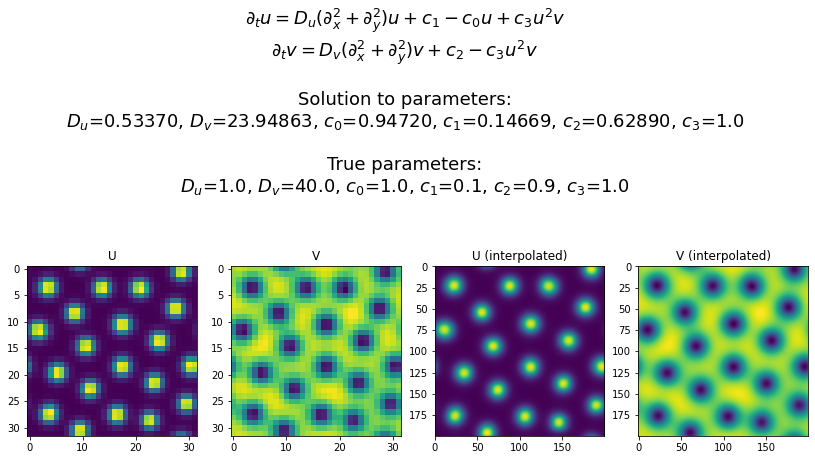

In [32]:
_ = plt.figure(figsize=(14,10))
# Direct solution
plt.suptitle(r"$\partial_t u = D_u (\partial_x^2 + \partial_y^2)u + c_1 -c_0 u + c_3u^2v$"
             "\n"
             r"$\partial_t v = D_v (\partial_x^2 + \partial_y^2)v + c_2 -c_3 u^2 v$"
             "\n"
             "\n"
             "Solution to parameters:\n" 
             r"$D_u$=0.53370, $D_v$=23.94863, $c_0$=0.94720, $c_1$=0.14669, $c_2$=0.62890, $c_3$=1.0"
             "\n"
             "\n"
             "True parameters:\n"
             r"$D_u$=1.0, $D_v$=40.0, $c_0$=1.0, $c_1$=0.1, $c_2$=0.9, $c_3$=1.0", 
             fontsize=18)
plt.subplot(141)
plt.title("U")
plt.imshow(c[0, :,:,-1])
plt.subplot(142)
plt.title("V")
plt.imshow(c[1, :,:,-1])
# Interpolated solutions
plt.subplot(143)
plt.title("U (interpolated)")
plt.imshow(c_interp[0, :,:,-1])
plt.subplot(144)
plt.title("V (interpolated)")
plt.imshow(c_interp[1, :,:,-1])
plt.show()

### Making an animation

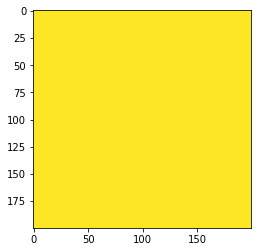

In [28]:
from matplotlib.animation import FuncAnimation


fig = plt.figure()

im = im=plt.imshow(c_interp[0, :,:,0])#  ,interpolation='none')
def init():
    im.set_data(c_interp[0, :,:,0])
    return [im]
    
def animate(i):    
    a=im.get_array()
    a=c_interp[0, :,:,i] 
    im.set_array(c_interp[0, :,:,i] )
    return [im]

anim = FuncAnimation(fig, animate, init_func=init,
                               frames=len(t), interval=50, blit=True)


anim.save('turring_FitzHugh_Nagumo.gif', writer='imagemagick')